In [1]:
import pandas as pd
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

## Reading the data

In [2]:
df_RSRP = pd.read_csv("RSRP.csv")
df_TV = pd.read_csv("TrafficVolume.csv")

## Data filtering and cleaning

**Checking the type of data fro each dataframe**

In [3]:
df_RSRP.dtypes

Timestamp                  object
LocationLatitude          float64
LocationLongitude         float64
RadioConnectionType        object
Country                    object
RadioNetworkGeneration     object
RadioOperatorName          object
RSRP                        int64
RadioMobileDataEnabled     object
DeviceManufacturer         object
DeviceName                 object
dtype: object

In [4]:
df_TV.dtypes

Timestamp                  object
LocationLatitude          float64
LocationLongitude         float64
RadioConnectionType        object
Country                    object
RadioNetworkGeneration     object
RadioOperatorName          object
TrafficDirection           object
TrafficVolume             float64
RadioMobileDataEnabled     object
dtype: object

**Slicing the string as the only used time are Hours and Minutes**

In [5]:
df_RSRP['Timestamp'] = df_RSRP.Timestamp.str.slice(0, 16)
df_TV['Timestamp'] = df_TV.Timestamp.str.slice(0, 16)

**Changing from string to date time formate for both datasets**

In [6]:
df_RSRP['Timestamp'] = pd.to_datetime(df_RSRP['Timestamp'], format = '%Y-%m-%d %H:%M')

**Here there are some worng in the data that when trying to reformat it an error always happen, then we will change this data that cause problems to NaT**

In [7]:
df_TV['Timestamp'] = pd.to_datetime(df_TV['Timestamp'], format = '%Y-%m-%d %H:%M', errors ='coerce')

**Checking NaNs**

In [8]:
df_TV.isnull().values.any()

True

In [9]:
df_TV.isnull().sum()

Timestamp                 80
LocationLatitude           0
LocationLongitude          0
RadioConnectionType        0
Country                    0
RadioNetworkGeneration     0
RadioOperatorName          0
TrafficDirection           0
TrafficVolume              0
RadioMobileDataEnabled     0
dtype: int64

**Only 80 records have problems, so dropping them is fine**

In [10]:
df_TV.dropna(inplace = True)

In [11]:
df_TV.isnull().values.any()

False

**Checking RSRP Data**

In [12]:
df_RSRP.isnull().values.any()

True

In [13]:
df_RSRP.isnull().sum()

Timestamp                   0
LocationLatitude            0
LocationLongitude           0
RadioConnectionType         0
Country                   156
RadioNetworkGeneration      0
RadioOperatorName           0
RSRP                        0
RadioMobileDataEnabled      0
DeviceManufacturer          0
DeviceName                  0
dtype: int64

In [14]:
df_RSRP.Country.unique()

array(['Saudi Arabia', nan], dtype=object)

**After finding that all the values of the Country is KSA except for only 156 records which are NaNs, therefore by default the NaNs are also KSA**  

Here I will be changing the NaNs to KSA

In [15]:
df_RSRP = df_RSRP.replace(np.nan, 'Saudi Arabia', regex=True)

**Re-checking again for NaNs**

In [16]:
df_RSRP.isnull().values.any()

False

**Removing the outliers from the RSRP dataset**

In [17]:
indexNames = df_RSRP[df_RSRP['RSRP'] > -40].index
df_RSRP.drop(indexNames , inplace=True)

**Sorting the data according to the Timestamp**

In [18]:
df_TV.sort_values(by='Timestamp',inplace=True)
df_RSRP.sort_values(by='Timestamp',inplace=True)

In [19]:
df_RSRP.reset_index(inplace=True, drop=True)
df_TV.reset_index(inplace=True, drop=True)

## Machine Learning

**By unsing Google Earth, the Polygon that will be used is a Square of Area 20*20 KM, its coordinates are as follow:**  

| Points      | Lat         | Long          |
| :----:      |    :----:   |     :----:    |
| Point A     | 24.833333   | 46.774444     |
| Point B     | 24.833333   | 46.574167     | 
| Point C     | 24.651111   | 46.774444     |
| Point D     | 24.651111   | 46.574167     | 

In [20]:
df_m = df_RSRP[(df_RSRP['LocationLatitude'] <= 24.833333) & (df_RSRP['LocationLatitude'] >= 24.651111) & (df_RSRP['LocationLongitude'] <= 46.774444) & (df_RSRP['LocationLongitude'] >= 46.574167)]
df_m.reset_index(inplace=True, drop=True)
df_m

,Timestamp,LocationLatitude,LocationLongitude,RadioConnectionType,Country,RadioNetworkGeneration,RadioOperatorName,RSRP,RadioMobileDataEnabled,DeviceManufacturer,DeviceName
0,2019-11-02 00:00:00,24.705570,46.621468,Mobile,Saudi Arabia,4G,Operator A,-90,Enabled,samsung,Galaxy A50
1,2019-11-02 00:00:00,24.823854,46.634785,Mobile,Saudi Arabia,4G,Operator B,-88,Enabled,HMD Global,Nokia 3.2
2,2019-11-02 00:00:00,24.746214,46.759760,Mobile,Saudi Arabia,4G,Operator C,-98,Enabled,samsung,Galaxy A7(2017)
3,2019-11-02 00:00:00,24.746181,46.759796,Mobile,Saudi Arabia,4G,Operator C,-98,Enabled,samsung,Galaxy A7(2017)
4,2019-11-02 00:00:00,24.792793,46.621410,Mobile,Saudi Arabia,4G,Operator B,-67,Enabled,samsung,Galaxy S6 Edge+
...,...,...,...,...,...,...,...,...,...,...,...
961158,2019-11-04 23:59:00,24.737455,46.591870,Mobile,Saudi Arabia,4G,Operator C,-103,Enabled,samsung,Galaxy A50
961159,2019-11-04 23:59:00,24.737606,46.592130,Mobile,Saudi Arabia,4G,Operator C,-99,Enabled,samsung,Galaxy A50
961160,2019-11-04 23:59:00,24.737713,46.592300,Mobile,Saudi Arabia,4G,Operator C,-99,Enabled,samsung,Galaxy A50
961161,2019-11-04 23:59:00,24.738080,46.592945,Mobile,Saudi Arabia,4G,Operator C,-101,Enabled,samsung,Galaxy A50


**This Coordinates are valid because this Polygon "Square" contains 961163 records, which is sufficient.**

### Comibining the two datasets

**Dropping the "Timestamp" column to merge the two datasets on them to use this merged dataframe later in training/testing**

In [21]:
df_m.drop(columns=["Timestamp"], inplace=True)

C:\Users\ahmed\anaconda3\envs\R and Python\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
df_T = df_TV.drop(columns=["Timestamp"])

**As we can see below, after mergging them, the output dataset contains 358596 records, which is considered fine to use later on**

In [23]:
merged = pd.merge(df_m,df_T)
merged

,LocationLatitude,LocationLongitude,RadioConnectionType,Country,RadioNetworkGeneration,RadioOperatorName,RSRP,RadioMobileDataEnabled,DeviceManufacturer,DeviceName,TrafficDirection,TrafficVolume
0,24.705570,46.621468,Mobile,Saudi Arabia,4G,Operator A,-90,Enabled,samsung,Galaxy A50,Downlink,2.602450
1,24.705570,46.621468,Mobile,Saudi Arabia,4G,Operator A,-95,Enabled,samsung,Galaxy A50,Downlink,2.602450
2,24.705570,46.621468,Mobile,Saudi Arabia,4G,Operator A,-107,Enabled,samsung,Galaxy A50,Downlink,2.602450
3,24.705570,46.621468,Mobile,Saudi Arabia,4G,Operator A,-95,Enabled,samsung,Galaxy A50,Downlink,2.602450
4,24.705570,46.621468,Mobile,Saudi Arabia,4G,Operator A,-94,Enabled,samsung,Galaxy A50,Downlink,2.602450
...,...,...,...,...,...,...,...,...,...,...,...,...
358591,24.719757,46.676160,Mobile,Saudi Arabia,4G,Operator A,-76,Enabled,samsung,Galaxy S9+,Downlink,0.638350
358592,24.719757,46.676160,Mobile,Saudi Arabia,4G,Operator A,-76,Enabled,samsung,Galaxy S9+,Downlink,0.961501
358593,24.719757,46.676160,Mobile,Saudi Arabia,4G,Operator A,-70,Enabled,samsung,Galaxy S9+,Downlink,0.638350
358594,24.719757,46.676160,Mobile,Saudi Arabia,4G,Operator A,-70,Enabled,samsung,Galaxy S9+,Downlink,0.961501


---------------------------------------

# Question 1: 
**Assuming that the coverage next week will improve in that polygon compared to competition (i.e., RSRP will get better than other operators). What would be the impact on downlink and uplink traffic volumes?**

### Steps:
  * Checking each column to drop the unused ones
  * Split the dataset to train/test/validation 
  * Increase the RSRP randomly with uplimit -40 to predict the Traffic Direction

In [24]:
merged["RadioConnectionType"].unique()

array(['Mobile', 'WiFi'], dtype=object)

In [25]:
merged["Country"].unique()

array(['Saudi Arabia'], dtype=object)

In [26]:
merged["RadioMobileDataEnabled"].unique()

array(['Enabled'], dtype=object)

In [27]:
merged["DeviceManufacturer"].unique()

array(['samsung', 'HMD Global', 'HUAWEI', 'HTC', 'Lenovo', 'Xiaomi',
       'OnePlus', 'vivo', 'OPPO', 'LENOVO', 'LGE', 'lenovo', 'Sony',
       'htc', 'motorola', 'TCL', 'realme', 'PANASONIC', 'LeEco'],
      dtype=object)

In [28]:
merged["DeviceManufacturer"] = merged["DeviceManufacturer"].str.upper()

In [29]:
merged["RadioOperatorName"].unique()

array(['Operator A', 'Operator B', 'Operator C'], dtype=object)

In [30]:
merged["RadioNetworkGeneration"].unique()

array(['4G', '3G'], dtype=object)

In [31]:
merged["DeviceName"].unique()

array(['Galaxy A50', 'Nokia 3.2', 'Galaxy S6 Edge+', 'Galaxy A20',
       'Galaxy J7', 'Galaxy A10', 'Galaxy A7(2017)', 'Huawei Y5 2019',
       'Htc U11+', 'Galaxy S9', 'K5 Note', 'Galaxy A7 (2018)',
       'Redmi Note 7 Pro', 'Galaxy S7', 'Galaxy Note4',
       'Galaxy On7(2016)', 'Galaxy J7 Prime', 'Galaxy J6', 'Oneplus6T',
       'Galaxy A10S', 'Y7', 'Galaxy Note9', 'Galaxy S10', 'Galaxy S9+',
       'Galaxy S8', 'Galaxy A20S', 'Galaxy S10+', 'Galaxy J7 Neo', 'Mi 9',
       'M10', 'Galaxy A70', 'Y9 Prime 2019', 'Huawei Y9S',
       'Huawei Y9 Prime 2019', 'Huawei P Smart Pro', 'Huawei Y7S',
       'Y7 Prime 2019', 'Huawei Y7 2019', 'Honor 9A', 'Galaxy A30',
       'Galaxy J6+', 'Huawei Y6 2019', 'Galaxy J4+', 'Galaxy On Nxt',
       'Nokia 6', 'Galaxy Grand Prime Plus', 'Nokia 6.1', 'P20Pro',
       'P20 Pro', 'Galaxy J5 Prime', 'Galaxy M30S', 'Galaxy Note8',
       'Galaxy S7 Edge', 'Oneplus5T', 'Desire 628 Dual Sim',
       'Htc Desire 628 Dual Sim', 'Vivo 1611', 'Mate 10 Pro',
 

**Dropping the columns that has only one record, which are RadioMobileDataEnabled & Country.**

In [32]:
merged.drop(columns=['RadioMobileDataEnabled', 'Country'], inplace=True)

**The number of records for each operator are as follow:** 

| Operator | Records |
|  :---:   |  :---:  |
|Operator A| 165581  |
|Operator B|  88016  |
|Operator C| 104999  |

Therfore **Operator A** will be used as it has the most number of records in order to test on them.

**Renaming the columns for easnies**

In [33]:
new_names = {'LocationLatitude':'Lat', 'LocationLongitude':'Long', 'RadioConnectionType':'ConnectionType',
             'RadioNetworkGeneration':'Network', 'RadioOperatorName':'Operator', 'DeviceManufacturer':'Device'}
merged.rename(columns=new_names, inplace=True)
merged

,Lat,Long,ConnectionType,Network,Operator,RSRP,Device,DeviceName,TrafficDirection,TrafficVolume
0,24.705570,46.621468,Mobile,4G,Operator A,-90,SAMSUNG,Galaxy A50,Downlink,2.602450
1,24.705570,46.621468,Mobile,4G,Operator A,-95,SAMSUNG,Galaxy A50,Downlink,2.602450
2,24.705570,46.621468,Mobile,4G,Operator A,-107,SAMSUNG,Galaxy A50,Downlink,2.602450
3,24.705570,46.621468,Mobile,4G,Operator A,-95,SAMSUNG,Galaxy A50,Downlink,2.602450
4,24.705570,46.621468,Mobile,4G,Operator A,-94,SAMSUNG,Galaxy A50,Downlink,2.602450
...,...,...,...,...,...,...,...,...,...,...
358591,24.719757,46.676160,Mobile,4G,Operator A,-76,SAMSUNG,Galaxy S9+,Downlink,0.638350
358592,24.719757,46.676160,Mobile,4G,Operator A,-76,SAMSUNG,Galaxy S9+,Downlink,0.961501
358593,24.719757,46.676160,Mobile,4G,Operator A,-70,SAMSUNG,Galaxy S9+,Downlink,0.638350
358594,24.719757,46.676160,Mobile,4G,Operator A,-70,SAMSUNG,Galaxy S9+,Downlink,0.961501


In [34]:
indexNames = merged[merged['TrafficVolume'] > 100].index
merged.drop(indexNames , inplace=True)
merged

,Lat,Long,ConnectionType,Network,Operator,RSRP,Device,DeviceName,TrafficDirection,TrafficVolume
0,24.705570,46.621468,Mobile,4G,Operator A,-90,SAMSUNG,Galaxy A50,Downlink,2.602450
1,24.705570,46.621468,Mobile,4G,Operator A,-95,SAMSUNG,Galaxy A50,Downlink,2.602450
2,24.705570,46.621468,Mobile,4G,Operator A,-107,SAMSUNG,Galaxy A50,Downlink,2.602450
3,24.705570,46.621468,Mobile,4G,Operator A,-95,SAMSUNG,Galaxy A50,Downlink,2.602450
4,24.705570,46.621468,Mobile,4G,Operator A,-94,SAMSUNG,Galaxy A50,Downlink,2.602450
...,...,...,...,...,...,...,...,...,...,...
358591,24.719757,46.676160,Mobile,4G,Operator A,-76,SAMSUNG,Galaxy S9+,Downlink,0.638350
358592,24.719757,46.676160,Mobile,4G,Operator A,-76,SAMSUNG,Galaxy S9+,Downlink,0.961501
358593,24.719757,46.676160,Mobile,4G,Operator A,-70,SAMSUNG,Galaxy S9+,Downlink,0.638350
358594,24.719757,46.676160,Mobile,4G,Operator A,-70,SAMSUNG,Galaxy S9+,Downlink,0.961501


**The data for Operator A will be modified and saved to a new dataset to use them later to meet the describtion that the coverage will improve "The RSRP will get better".**

In [35]:
df_test = copy.deepcopy(merged)

In [36]:
index = df_test[(df_test["Operator"] == "Operator A") & (df_test["RSRP"] < -70)].index

In [37]:
df_test["RSRP"][index] = df_test["RSRP"][index] + random.randint(0,30)
df_test

C:\Users\ahmed\anaconda3\envs\R and Python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\ahmed\anaconda3\envs\R and Python\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Lat,Long,ConnectionType,Network,Operator,RSRP,Device,DeviceName,TrafficDirection,TrafficVolume
0,24.705570,46.621468,Mobile,4G,Operator A,-78,SAMSUNG,Galaxy A50,Downlink,2.602450
1,24.705570,46.621468,Mobile,4G,Operator A,-83,SAMSUNG,Galaxy A50,Downlink,2.602450
2,24.705570,46.621468,Mobile,4G,Operator A,-95,SAMSUNG,Galaxy A50,Downlink,2.602450
3,24.705570,46.621468,Mobile,4G,Operator A,-83,SAMSUNG,Galaxy A50,Downlink,2.602450
4,24.705570,46.621468,Mobile,4G,Operator A,-82,SAMSUNG,Galaxy A50,Downlink,2.602450
...,...,...,...,...,...,...,...,...,...,...
358591,24.719757,46.676160,Mobile,4G,Operator A,-64,SAMSUNG,Galaxy S9+,Downlink,0.638350
358592,24.719757,46.676160,Mobile,4G,Operator A,-64,SAMSUNG,Galaxy S9+,Downlink,0.961501
358593,24.719757,46.676160,Mobile,4G,Operator A,-70,SAMSUNG,Galaxy S9+,Downlink,0.638350
358594,24.719757,46.676160,Mobile,4G,Operator A,-70,SAMSUNG,Galaxy S9+,Downlink,0.961501


## Applying the Machine Learning

### Importing the libraries that will be used later on

In [38]:
# Statistics Library
from scipy import stats

# Time Library
import time
from time import process_time

# Modeling
from sklearn.inspection import permutation_importance
from sklearn import linear_model, ensemble
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline


## Linear Regression

**To use Linear Regression approaches , we need to change the categorical values to integer:**  

In [39]:
merged.Device.value_counts()

SAMSUNG       283480
HUAWEI         33514
HTC            23517
XIAOMI          3904
HMD GLOBAL      3794
OPPO            2310
LENOVO          1911
MOTOROLA        1579
TCL              791
LGE              320
ONEPLUS          320
REALME           120
SONY              57
PANASONIC         20
VIVO               3
LEECO              2
Name: Device, dtype: int64

In [40]:
merged.DeviceName.value_counts()

Galaxy A10             58274
Galaxy S6 Edge+        29635
Galaxy J7 Prime        28568
Galaxy On7(2016)       27600
Galaxy J6              21449
                       ...  
Nokia 8                    2
Lenovo A6 Note             2
Reno2 Z                    2
Desire 828 Dual Sim        2
Xperia L1                  1
Name: DeviceName, Length: 167, dtype: int64

### 1. Resampling the dataset

In [41]:
dm = pd.unique(merged['Device'])
dn = pd.unique(merged['DeviceName'])

In [42]:
dm_i = np.arange(1, 17).tolist()
dn_i = np.arange(1, 168).tolist()

In [43]:
# RadioConnectionType, RadioNetworkGeneration, RadioOperatorName, DeviceManufacturer, DeviceName and
# TrafficDirection should be numerical columns
merged['ConnectionType'].replace(to_replace=['Mobile', 'WiFi'], value=[1, 2], inplace=True)

merged['Network'].replace(to_replace=['3G', '4G'], value=[1, 2], inplace=True)

merged['Operator'].replace(to_replace=['Operator A', 'Operator B', 'Operator C'], value=[1, 2, 3], inplace=True)

merged['Device'].replace(to_replace=dm, value=dm_i, inplace=True)

merged['DeviceName'].replace(to_replace=dn, value=dn_i, inplace=True)

merged['TrafficDirection'].replace(to_replace=['Downlink', 'Uplink'], value=[1, 2], inplace=True)

In [44]:
merged

,Lat,Long,ConnectionType,Network,Operator,RSRP,Device,DeviceName,TrafficDirection,TrafficVolume
0,24.705570,46.621468,1,2,1,-90,1,1,1,2.602450
1,24.705570,46.621468,1,2,1,-95,1,1,1,2.602450
2,24.705570,46.621468,1,2,1,-107,1,1,1,2.602450
3,24.705570,46.621468,1,2,1,-95,1,1,1,2.602450
4,24.705570,46.621468,1,2,1,-94,1,1,1,2.602450
...,...,...,...,...,...,...,...,...,...,...
358591,24.719757,46.676160,1,2,1,-76,1,24,1,0.638350
358592,24.719757,46.676160,1,2,1,-76,1,24,1,0.961501
358593,24.719757,46.676160,1,2,1,-70,1,24,1,0.638350
358594,24.719757,46.676160,1,2,1,-70,1,24,1,0.961501


In [45]:
merged[merged['TrafficVolume'] > 10]

,Lat,Long,ConnectionType,Network,Operator,RSRP,Device,DeviceName,TrafficDirection,TrafficVolume
10,24.823854,46.634785,1,2,2,-88,2,2,1,10.328836
28111,24.691420,46.652760,1,2,1,-81,3,8,1,41.834898
28162,24.691420,46.652760,1,2,1,-87,3,8,1,41.834898
28213,24.691420,46.652760,1,2,1,-87,3,8,1,41.834898
28264,24.691420,46.652760,1,2,1,-86,3,8,1,41.834898
...,...,...,...,...,...,...,...,...,...,...
358523,24.779324,46.717600,1,2,2,-94,1,43,1,19.202733
358525,24.779324,46.717600,1,2,2,-89,1,43,1,19.202733
358527,24.779324,46.717600,1,2,2,-92,1,43,1,19.202733
358532,24.770271,46.620308,1,2,2,-99,1,22,1,14.148184


### 2. Splitting the dataset:

In [46]:
X = merged.drop(["TrafficVolume"], axis=1)
y = merged["TrafficVolume"]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
def scale_data(X_train, X_test):
    """
    Input: Features (numpy arrays)
    Output: Scaled data
    """
    pipeline = Pipeline([('std_scalar', StandardScaler())])

    X_train_scaled = pipeline.fit_transform(X_train)
    X_test_scaled = pipeline.transform(X_test)

    return X_train_scaled, X_test_scaled

In [49]:
X_train, X_test = scale_data(X_train, X_test)

In [66]:
print('Shape of X training set {}'.format(X_train.shape),'&',' Size of Y training set {}'.format(y_train.shape))

Shape of X training set (248949, 9) &  Size of Y training set (248949,)


In [67]:
print('Shape of X training set {}'.format(X_test.shape),'&',' Size of Y training set {}'.format(y_test.shape))

Shape of X training set (106693, 9) &  Size of Y training set (106693,)


In [57]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)

LinearRegression(normalize=True)

In [58]:
print(lin_reg.intercept_)

5.431631492646977


In [70]:
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
Lat,-1.789896
Long,0.973148
ConnectionType,0.372793
Network,0.312812
Operator,2.241122
RSRP,0.362900
Device,-0.399111
DeviceName,-1.532846
TrafficDirection,-3.891136


In [71]:
pred = lin_reg.predict(X_test)

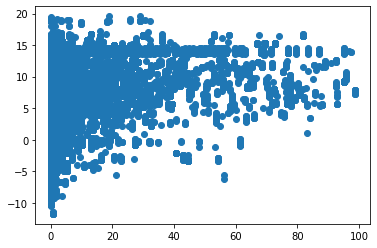

In [72]:
plt.scatter(y_test, pred)

C:\Users\ahmed\anaconda3\envs\R and Python\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


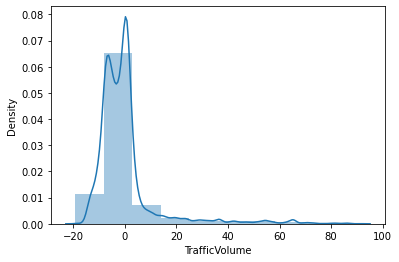

In [73]:
sns.distplot((y_test - pred), bins=10);

In [53]:
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

### Linear Regression

In [59]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 6.916856252380238
MSE: 156.77428261285658
RMSE: 12.520953742141874
R2 Square 0.13968942405112106
__________________________________
Train set evaluation:
_____________________________________
MAE: 6.94613384586044
MSE: 157.2651165845104
RMSE: 12.540538927195689
R2 Square 0.14087015580805118
__________________________________


In [60]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,6.916856,156.774283,12.520954,0.139689,-0.041306


### Robust Regression

In [61]:
from sklearn.linear_model import RANSACRegressor

model = RANSACRegressor(base_estimator=LinearRegression(), max_trials=100)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 5.289775315683563
MSE: 208.56238656244807
RMSE: 14.441689186603071
R2 Square -0.14450166133369424
__________________________________
Train set evaluation:
_____________________________________
MAE: 5.304384515677196
MSE: 209.51438510824852
RMSE: 14.474611742918997
R2 Square -0.14456444597040652
__________________________________


In [62]:
results_df_2 = pd.DataFrame(data=[["Robust Regression", *evaluate(y_test, test_pred) , cross_val(RANSACRegressor())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,6.916856,156.774283,12.520954,0.139689,-0.041306
1,Robust Regression,5.289775,208.562387,14.441689,-0.144502,-0.139502


### Ridge Regression

In [63]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 6.916033300336311
MSE: 156.77426044090763
RMSE: 12.52095285674807
R2 Square 0.13968954572134562
__________________________________
Train set evaluation:
_____________________________________
MAE: 6.9453002837905835
MSE: 157.26512167385903
RMSE: 12.540539130111553
R2 Square 0.14087012800524656
__________________________________


In [64]:
results_df_2 = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred) , cross_val(Ridge())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,6.916856,156.774283,12.520954,0.139689,-0.041306
1,Robust Regression,5.289775,208.562387,14.441689,-0.144502,-0.139502
2,Ridge Regression,6.916033,156.774260,12.520953,0.139690,-0.041314


### Polynomial Regression

In [65]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)

X_train_2_d = poly_reg.fit_transform(X_train)
X_test_2_d = poly_reg.transform(X_test)

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train_2_d,y_train)

test_pred = lin_reg.predict(X_test_2_d)
train_pred = lin_reg.predict(X_train_2_d)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 6.37560553564859
MSE: 141.42057476017345
RMSE: 11.892038292915704
R2 Square 0.22394404174445315
__________________________________
Train set evaluation:
_____________________________________
MAE: 6.399599888786237
MSE: 141.29000942399318
RMSE: 11.886547413946287
R2 Square 0.22814120245741742
__________________________________


In [66]:
results_df_2 = pd.DataFrame(data=[["Polynomail Regression 2", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,6.916856,156.774283,12.520954,0.139689,-0.041306
1,Robust Regression,5.289775,208.562387,14.441689,-0.144502,-0.139502
2,Ridge Regression,6.916033,156.774260,12.520953,0.139690,-0.041314
3,Polynomail Regression 2,6.375606,141.420575,11.892038,0.223944,0.000000


### Stochastic Gradient Descen

In [67]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(n_iter_no_change=250, penalty=None, eta0=0.0001, max_iter=100000)
sgd_reg.fit(X_train, y_train)

test_pred = sgd_reg.predict(X_test)
train_pred = sgd_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 6.916447108334103
MSE: 156.77411168639304
RMSE: 12.520946916523249
R2 Square 0.1396903620228459
__________________________________
Train set evaluation:
_____________________________________
MAE: 6.945729505850627
MSE: 157.26511943870278
RMSE: 12.540539040994322
R2 Square 0.14087014021577027
__________________________________


In [68]:
results_df_2 = pd.DataFrame(data=[["Stochastic Gradient Descent", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,6.916856,156.774283,12.520954,0.139689,-0.041306
1,Robust Regression,5.289775,208.562387,14.441689,-0.144502,-0.139502
2,Ridge Regression,6.916033,156.774260,12.520953,0.139690,-0.041314
3,Polynomail Regression 2,6.375606,141.420575,11.892038,0.223944,0.000000
4,Stochastic Gradient Descent,6.916447,156.774112,12.520947,0.139690,0.000000


### LASSO Regression

In [69]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.1, 
              precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=42)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 7.207404418246183
MSE: 176.25376682050498
RMSE: 13.276059913261351
R2 Square 0.032794300702013834
__________________________________
Train set evaluation:
_____________________________________
MAE: 7.222326845516281
MSE: 176.7901092917551
RMSE: 13.296244179908667
R2 Square 0.03420629857935742
__________________________________


In [70]:
results_df_2 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test, test_pred) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,6.916856,156.774283,12.520954,0.139689,-0.041306
1,Robust Regression,5.289775,208.562387,14.441689,-0.144502,-0.139502
2,Ridge Regression,6.916033,156.774260,12.520953,0.139690,-0.041314
3,Polynomail Regression 2,6.375606,141.420575,11.892038,0.223944,0.000000
4,Stochastic Gradient Descent,6.916447,156.774112,12.520947,0.139690,0.000000
5,Lasso Regression,7.207404,176.253767,13.276060,0.032794,-0.054763


### Elastic Net

In [71]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 6.818851320834772
MSE: 156.88447078193184
RMSE: 12.525353120049424
R2 Square 0.13908475824994504
__________________________________
Train set evaluation:
_____________________________________
MAE: 6.846428104154561
MSE: 157.37379242142353
RMSE: 12.544871160016891
R2 Square 0.14027646626734214
__________________________________


In [72]:
results_df_2 = pd.DataFrame(data=[["Elastic Net Regression", *evaluate(y_test, test_pred) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,6.916856,156.774283,12.520954,0.139689,-0.041306
1,Robust Regression,5.289775,208.562387,14.441689,-0.144502,-0.139502
2,Ridge Regression,6.916033,156.774260,12.520953,0.139690,-0.041314
3,Polynomail Regression 2,6.375606,141.420575,11.892038,0.223944,0.000000
4,Stochastic Gradient Descent,6.916447,156.774112,12.520947,0.139690,0.000000
5,Lasso Regression,7.207404,176.253767,13.276060,0.032794,-0.054763
6,Elastic Net Regression,6.818851,156.884471,12.525353,0.139085,-0.072347


### Random Forest Regressor

In [73]:
rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_train, y_train)

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 3.876640831653686
MSE: 87.71977656387632
RMSE: 9.365883650989709
R2 Square 0.5186311795529999
__________________________________
Train set evaluation:
_____________________________________
MAE: 3.6829660069738317
MSE: 79.8048670909589
RMSE: 8.933356988890509
R2 Square 0.5640308256613871
__________________________________


In [74]:
results_df_2 = pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,6.916856,156.774283,12.520954,0.139689,-0.041306
1,Robust Regression,5.289775,208.562387,14.441689,-0.144502,-0.139502
2,Ridge Regression,6.916033,156.774260,12.520953,0.139690,-0.041314
3,Polynomail Regression 2,6.375606,141.420575,11.892038,0.223944,0.000000
4,Stochastic Gradient Descent,6.916447,156.774112,12.520947,0.139690,0.000000
5,Lasso Regression,7.207404,176.253767,13.276060,0.032794,-0.054763
6,Elastic Net Regression,6.818851,156.884471,12.525353,0.139085,-0.072347
7,Random Forest Regressor,3.876641,87.719777,9.365884,0.518631,0.000000


**This Model *SVR* is very expensive in terms of time so it was excluded**

PS: Don't run it, else on your responsbility

```python
from sklearn.svm import SVR

svm_reg = SVR(kernel='rbf', C=1000000, epsilon=0.001)
svm_reg.fit(X_train, y_train)

test_pred = svm_reg.predict(X_test)
train_pred = svm_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)
```

```python
results_df_2 = pd.DataFrame(data=[["SVM Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df
```

## NN

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()

model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer=Adam(0.00001), loss='mse')

r = model.fit(X_train, y_train,
              validation_data=(X_test,y_test),
              batch_size=1,
              epochs=100)

C:\Users\ahmed\anaconda3\envs\R and Python\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ahmed\anaconda3\envs\R and Python\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ahmed\anaconda3\envs\R and Python\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ahmed\anaconda3\envs\R and Python\lib\site-

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 248949 samples, validate on 106693 samples
Epoch 1/100
248949/248949 [==============================] - 364s 1ms/sample - loss: 144.2772 - val_loss: 131.9067
Epoch 2/100
248949/248949 [==============================] - 334s 1ms/sample - loss: 125.1709 - val_loss: 122.4504
Epoch 3/100
248949/248949 [==============================] - 302s 1ms/sample - loss: 119.5476 - val_loss: 119.0532
Epoch 4/100
248949/248949 [==============================] - 322s 1ms/sample - loss: 117.2868 - val_loss: 117.9515
Epoch 5/100
248949/248949 [==============================] - 322s 1ms/sample - loss: 115.9285 - val_loss: 115.7837
Epoch 6/100
248949/248949 [==============================] - 324s 1ms/sample - loss: 114.7505 - val_loss: 115.0233
Epoch 7/100
248949/248949 [==============================] - 325s 1ms/sample - loss: 113.9393 - val_loss: 114.4708
Epoch 8/100
248949/248949

Epoch 68/100
248949/248949 [==============================] - 340s 1ms/sample - loss: 102.8698 - val_loss: 105.0642
Epoch 69/100
248949/248949 [==============================] - 309s 1ms/sample - loss: 102.6784 - val_loss: 103.0827
Epoch 70/100
248949/248949 [==============================] - 341s 1ms/sample - loss: 102.7513 - val_loss: 104.2750
Epoch 71/100
248949/248949 [==============================] - 317s 1ms/sample - loss: 102.6298 - val_loss: 103.3395
Epoch 72/100
248949/248949 [==============================] - 317s 1ms/sample - loss: 102.6952 - val_loss: 103.1520
Epoch 73/100
248949/248949 [==============================] - 311s 1ms/sample - loss: 102.6298 - val_loss: 106.2481
Epoch 74/100
248949/248949 [==============================] - 308s 1ms/sample - loss: 102.5638 - val_loss: 103.4724
Epoch 75/100
248949/248949 [==============================] - 312s 1ms/sample - loss: 102.5334 - val_loss: 104.1706
Epoch 76/100
248949/248949 [==============================] - 332s 1ms/s

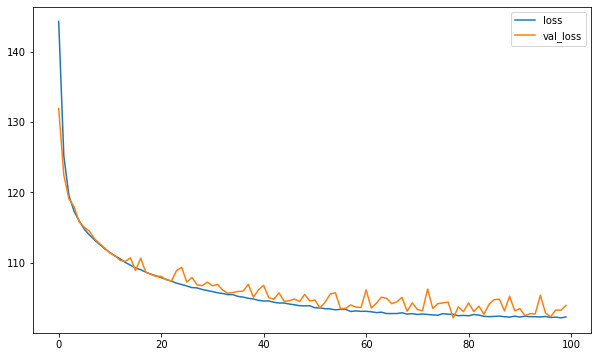

In [51]:
plt.figure(figsize=(10, 6))

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [55]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
nn_test = test_pred
nn_train = train_pred
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 4.686927531006252
MSE: 103.91987361825406
RMSE: 10.194109751138352
R2 Square 0.42973193794909337
__________________________________
Train set evaluation:
_____________________________________
MAE: 4.669787282889854
MSE: 101.89135431847292
RMSE: 10.094124742565494
R2 Square 0.443373678401875
__________________________________


In [75]:
results_df_2 = pd.DataFrame(data=[["Artficial Neural Network", *evaluate(y_test, nn_test), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,6.916856,156.774283,12.520954,0.139689,-0.041306
1,Robust Regression,5.289775,208.562387,14.441689,-0.144502,-0.139502
2,Ridge Regression,6.916033,156.774260,12.520953,0.139690,-0.041314
3,Polynomail Regression 2,6.375606,141.420575,11.892038,0.223944,0.000000
4,Stochastic Gradient Descent,6.916447,156.774112,12.520947,0.139690,0.000000
5,Lasso Regression,7.207404,176.253767,13.276060,0.032794,-0.054763
6,Elastic Net Regression,6.818851,156.884471,12.525353,0.139085,-0.072347
7,Random Forest Regressor,3.876641,87.719777,9.365884,0.518631,0.000000
8,Artficial Neural Network,4.686928,103.919874,10.194110,0.429732,0.000000


**As we an see, the best two models are Random Forest and Neural Network, since the NN takes a lot of time to tune and no time to waste, so I will move on to optimize the Random Forest**

## Optimization

### Feature Importance

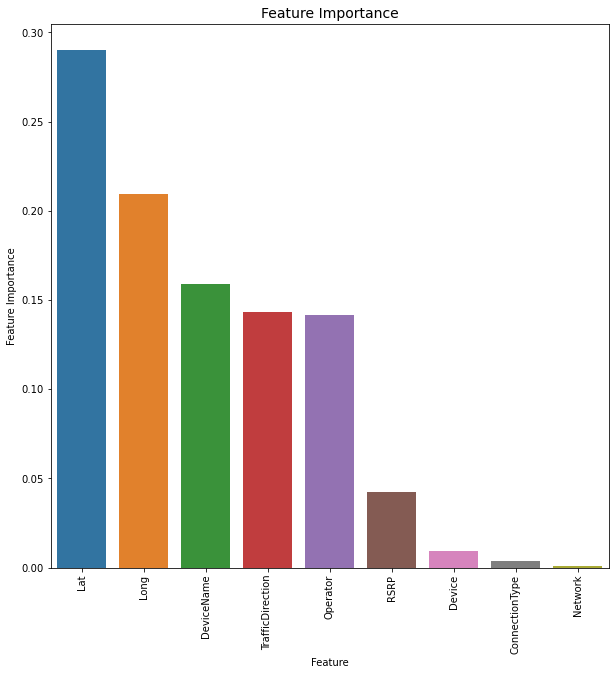

In [76]:
temp = pd.DataFrame({'Feature': list(X.columns), 'Feature Importance': rf_reg.feature_importances_})
temp = temp.sort_values(by="Feature Importance", ascending=False)

plt.figure(figsize=(10,10))
plt.title('Feature Importance', fontsize=14)
s=sns.barplot(x='Feature', y='Feature Importance', data=temp)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.show();

In [78]:
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(rf_reg.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Lat                  Importance: 0.29
Variable: Long                 Importance: 0.21
Variable: DeviceName           Importance: 0.16
Variable: Operator             Importance: 0.14
Variable: TrafficDirection     Importance: 0.14
Variable: RSRP                 Importance: 0.04
Variable: Device               Importance: 0.01
Variable: ConnectionType       Importance: 0.0
Variable: Network              Importance: 0.0


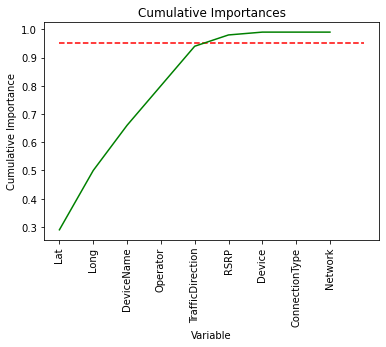

In [80]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

### Limiting number of features

In [82]:
# Find number of features for cumulative importance of 95%
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 6


In [84]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:6]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
important_train_features = X_train[:, important_indices]
important_test_features = X_test[:, important_indices]

# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Important train features shape: (248949, 6)
Important test features shape: (106693, 6)


### Train & Evaluate on Important features

In [87]:
# Make predictions on data
test_pred = rf_reg.predict(important_test_features)
train_pred = rf_reg.predict(important_train_features)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 3.8785868967333954
MSE: 87.76139855602936
RMSE: 9.36810538775207
R2 Square 0.5184027757647985
__________________________________
Train set evaluation:
_____________________________________
MAE: 3.6862847587399017
MSE: 79.87043784074649
RMSE: 8.937026230281887
R2 Square 0.563672616611141
__________________________________


In [88]:
results_df_2 = pd.DataFrame(data=[["Optimized Random Forest", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,6.916856,156.774283,12.520954,0.139689,-0.041306
1,Robust Regression,5.289775,208.562387,14.441689,-0.144502,-0.139502
2,Ridge Regression,6.916033,156.774260,12.520953,0.139690,-0.041314
3,Polynomail Regression 2,6.375606,141.420575,11.892038,0.223944,0.000000
4,Stochastic Gradient Descent,6.916447,156.774112,12.520947,0.139690,0.000000
5,Lasso Regression,7.207404,176.253767,13.276060,0.032794,-0.054763
6,Elastic Net Regression,6.818851,156.884471,12.525353,0.139085,-0.072347
7,Random Forest Regressor,3.876641,87.719777,9.365884,0.518631,0.000000
8,Artficial Neural Network,4.686928,103.919874,10.194110,0.429732,0.000000
9,Optimized Random Forest,3.878587,87.761399,9.368105,0.518403,0.000000


## Hyperparameter Tunning

In [90]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf_reg.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


### Random Search Training

In [92]:
# Number of trees in random forest
n_estimators = [50,100,150,200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,8,14,20, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

**This is very expensive in terms of time as it almost took 12hrs, so another approaches are going to be considered**

In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_reg, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 71.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 399.2min


In [94]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_reg, param_distributions = random_grid, n_iter = 10, cv = 5, random_state=42, verbose=2)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.cv_results_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=  10.7s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=  10.6s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=  10.6s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=  10.7s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=  11.3s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=150, min

[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=14, bootstrap=True, total=  41.7s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=14, bootstrap=True, total=  49.7s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=14, bootstrap=True, total= 1.0min
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=14, bootstrap=True, total=  41.1s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=100, min_samples_

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 22.6min finished


{'mean_fit_time': array([10.27054534, 72.3035316 ,  8.28630328, 27.53358073, 41.71680655,
         4.66710935,  9.36264806, 45.84185672, 26.79670968, 18.41819592]),
 'std_fit_time': array([0.2598069 , 2.80878073, 0.23251014, 1.99075566, 4.19268148,
        0.05699887, 0.11916583, 7.88791822, 4.54149804, 0.71089633]),
 'mean_score_time': array([0.48292117, 1.9187932 , 0.19293394, 0.96838145, 0.3440805 ,
        0.12606406, 0.25990529, 0.68317351, 0.68277311, 0.20285645]),
 'std_score_time': array([0.01061206, 0.20592492, 0.016702  , 0.08291482, 0.04076538,
        0.01045259, 0.01139942, 0.05318308, 0.18856666, 0.00610245]),
 'param_n_estimators': masked_array(data=[50, 150, 150, 150, 100, 100, 200, 100, 50, 150],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[5, 2, 5, 5, 10, 5, 2, 2, 5, 5],
              mask=[False, False, F

In [95]:
rf_random.best_params_

{'n_estimators': 50,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [97]:
best_random = rf_random.best_estimator_

# Make predictions on data
test_pred = best_random.predict(X_test)
train_pred = best_random.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 3.904941547662413
MSE: 86.47216502493036
RMSE: 9.29904108093573
R2 Square 0.525477540982582
__________________________________
Train set evaluation:
_____________________________________
MAE: 3.7677538057057545
MSE: 80.67197630697667
RMSE: 8.98175797419284
R2 Square 0.5592938603264557
__________________________________


In [98]:
results_df_2 = pd.DataFrame(data=[["RS-Tunning Random Forest", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,6.916856,156.774283,12.520954,0.139689,-0.041306
1,Robust Regression,5.289775,208.562387,14.441689,-0.144502,-0.139502
2,Ridge Regression,6.916033,156.774260,12.520953,0.139690,-0.041314
3,Polynomail Regression 2,6.375606,141.420575,11.892038,0.223944,0.000000
4,Stochastic Gradient Descent,6.916447,156.774112,12.520947,0.139690,0.000000
5,Lasso Regression,7.207404,176.253767,13.276060,0.032794,-0.054763
6,Elastic Net Regression,6.818851,156.884471,12.525353,0.139085,-0.072347
7,Random Forest Regressor,3.876641,87.719777,9.365884,0.518631,0.000000
8,Artficial Neural Network,4.686928,103.919874,10.194110,0.429732,0.000000
9,Optimized Random Forest,3.878587,87.761399,9.368105,0.518403,0.000000


**The other approach that will be used is Grid Search**

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

**Due time, GridSearchCV will not be used and we will move forwad with the output of RandomSearchCV which is 52.5% not that good, but that what we have right now to work with, so moving forward.**

A dataset was intiated perviously in this notebook to use it later after we choose the model, this dataset is called: **df_test**

In [107]:
df_test.drop(columns=['TrafficVolume'], inplace=True)
df_test

,Lat,Long,ConnectionType,Network,Operator,RSRP,Device,DeviceName,TrafficDirection
0,24.705570,46.621468,Mobile,4G,Operator A,-78,SAMSUNG,Galaxy A50,Downlink
1,24.705570,46.621468,Mobile,4G,Operator A,-83,SAMSUNG,Galaxy A50,Downlink
2,24.705570,46.621468,Mobile,4G,Operator A,-95,SAMSUNG,Galaxy A50,Downlink
3,24.705570,46.621468,Mobile,4G,Operator A,-83,SAMSUNG,Galaxy A50,Downlink
4,24.705570,46.621468,Mobile,4G,Operator A,-82,SAMSUNG,Galaxy A50,Downlink
...,...,...,...,...,...,...,...,...,...
358591,24.719757,46.676160,Mobile,4G,Operator A,-64,SAMSUNG,Galaxy S9+,Downlink
358592,24.719757,46.676160,Mobile,4G,Operator A,-64,SAMSUNG,Galaxy S9+,Downlink
358593,24.719757,46.676160,Mobile,4G,Operator A,-70,SAMSUNG,Galaxy S9+,Downlink
358594,24.719757,46.676160,Mobile,4G,Operator A,-70,SAMSUNG,Galaxy S9+,Downlink


In [109]:
dm = pd.unique(df_test['Device'])
dn = pd.unique(df_test['DeviceName'])

In [110]:
dm_i = np.arange(1, 17).tolist()
dn_i = np.arange(1, 168).tolist()

In [111]:
# RadioConnectionType, RadioNetworkGeneration, RadioOperatorName, DeviceManufacturer, DeviceName and
# TrafficDirection should be numerical columns
df_test['ConnectionType'].replace(to_replace=['Mobile', 'WiFi'], value=[1, 2], inplace=True)

df_test['Network'].replace(to_replace=['3G', '4G'], value=[1, 2], inplace=True)

df_test['Operator'].replace(to_replace=['Operator A', 'Operator B', 'Operator C'], value=[1, 2, 3], inplace=True)

df_test['Device'].replace(to_replace=dm, value=dm_i, inplace=True)

df_test['DeviceName'].replace(to_replace=dn, value=dn_i, inplace=True)

df_test['TrafficDirection'].replace(to_replace=['Downlink', 'Uplink'], value=[1, 2], inplace=True)

In [112]:
output = best_random.predict(df_test)

In [114]:
df_test["Predicted TV"] = output
df_test

,Lat,Long,ConnectionType,Network,Operator,RSRP,Device,DeviceName,TrafficDirection,Predicted TV
0,24.705570,46.621468,1,2,1,-78,1,1,1,4.261859
1,24.705570,46.621468,1,2,1,-83,1,1,1,4.261859
2,24.705570,46.621468,1,2,1,-95,1,1,1,4.261859
3,24.705570,46.621468,1,2,1,-83,1,1,1,4.261859
4,24.705570,46.621468,1,2,1,-82,1,1,1,4.261859
...,...,...,...,...,...,...,...,...,...,...
358591,24.719757,46.676160,1,2,1,-64,1,24,1,2.642819
358592,24.719757,46.676160,1,2,1,-64,1,24,1,2.642819
358593,24.719757,46.676160,1,2,1,-70,1,24,1,2.642819
358594,24.719757,46.676160,1,2,1,-70,1,24,1,2.642819


In [115]:
df_test['ConnectionType'].replace(to_replace=[1, 2], value=['Mobile', 'WiFi'], inplace=True)

df_test['Network'].replace(to_replace=[1, 2], value=['3G', '4G'], inplace=True)

df_test['Operator'].replace(to_replace=[1, 2, 3], value=['Operator A', 'Operator B', 'Operator C'], inplace=True)

df_test['Device'].replace(to_replace=dm_i, value=dm, inplace=True)

df_test['DeviceName'].replace(to_replace=dn_i, value=dn, inplace=True)

df_test['TrafficDirection'].replace(to_replace=[1, 2], value=['Downlink', 'Uplink'], inplace=True)

In [116]:
df_test

,Lat,Long,ConnectionType,Network,Operator,RSRP,Device,DeviceName,TrafficDirection,Predicted TV
0,24.705570,46.621468,Mobile,4G,Operator A,-78,SAMSUNG,Galaxy A50,Downlink,4.261859
1,24.705570,46.621468,Mobile,4G,Operator A,-83,SAMSUNG,Galaxy A50,Downlink,4.261859
2,24.705570,46.621468,Mobile,4G,Operator A,-95,SAMSUNG,Galaxy A50,Downlink,4.261859
3,24.705570,46.621468,Mobile,4G,Operator A,-83,SAMSUNG,Galaxy A50,Downlink,4.261859
4,24.705570,46.621468,Mobile,4G,Operator A,-82,SAMSUNG,Galaxy A50,Downlink,4.261859
...,...,...,...,...,...,...,...,...,...,...
358591,24.719757,46.676160,Mobile,4G,Operator A,-64,SAMSUNG,Galaxy S9+,Downlink,2.642819
358592,24.719757,46.676160,Mobile,4G,Operator A,-64,SAMSUNG,Galaxy S9+,Downlink,2.642819
358593,24.719757,46.676160,Mobile,4G,Operator A,-70,SAMSUNG,Galaxy S9+,Downlink,2.642819
358594,24.719757,46.676160,Mobile,4G,Operator A,-70,SAMSUNG,Galaxy S9+,Downlink,2.642819


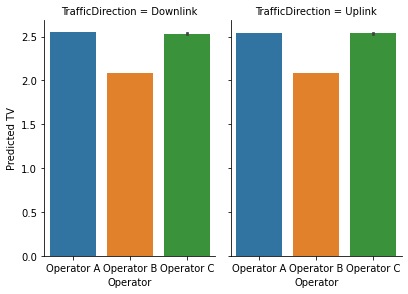

In [119]:
g = sns.catplot(x='Operator', y='Predicted TV',
                col='TrafficDirection',
                data=df_test, kind="bar",
                height=4, aspect=.7);

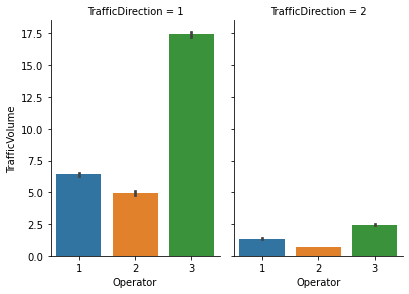

In [121]:
g = sns.catplot(x='Operator', y='TrafficVolume',
                col='TrafficDirection',
                data=merged, kind="bar",
                height=4, aspect=.7);

**As was described earlier, the Traffic Volume more than 100 was discarded as it caused too much noises and outliers in the data. So for the output here, using Tuned Random Forest caused the Uplink to significantly increase from below 1.5 to more than 2.5, where in the downlink we can consider there is a slighlt increase as in the real data, Operator C is significanlty higher than Operator B and A, while after training the model, operator A almost reached Operator C in both UpLink and DownLink.**

**So in conclusion, RSRP is directly proportion and has high influence on increasing the Traffic Volume**

------------------------------------------------

# Question 2  
**Samsung devices are the main handsets in our network. Can you predict
the traffic volume growth, uplink and downlink, over time for these devices
and compare it to the competitors?**

Intiating another test dataset where the RSRP for all the Operators are enhanced to use it accordingly

In [142]:
df_test2 = copy.deepcopy(merged)
df_test2["RSRP"] = df_test2["RSRP"] + random.randint(0,30)

In [143]:
df_test2.drop(columns=['TrafficVolume'], inplace=True)

In [149]:
output = best_random.predict(df_test2)

In [150]:
df_test2["Predicted TV"] = output
df_test2

,Lat,Long,ConnectionType,Network,Operator,RSRP,Device,DeviceName,TrafficDirection,Predicted TV
0,24.705570,46.621468,1,2,1,-61,1,1,1,4.261859
1,24.705570,46.621468,1,2,1,-66,1,1,1,4.261859
2,24.705570,46.621468,1,2,1,-78,1,1,1,4.261859
3,24.705570,46.621468,1,2,1,-66,1,1,1,4.261859
4,24.705570,46.621468,1,2,1,-65,1,1,1,4.261859
...,...,...,...,...,...,...,...,...,...,...
358591,24.719757,46.676160,1,2,1,-47,1,24,1,2.642819
358592,24.719757,46.676160,1,2,1,-47,1,24,1,2.642819
358593,24.719757,46.676160,1,2,1,-41,1,24,1,2.642819
358594,24.719757,46.676160,1,2,1,-41,1,24,1,2.642819


In [151]:
df_test['ConnectionType'].replace(to_replace=[1, 2], value=['Mobile', 'WiFi'], inplace=True)

df_test['Network'].replace(to_replace=[1, 2], value=['3G', '4G'], inplace=True)

df_test['Operator'].replace(to_replace=[1, 2, 3], value=['Operator A', 'Operator B', 'Operator C'], inplace=True)

df_test['Device'].replace(to_replace=dm_i, value=dm, inplace=True)

df_test['DeviceName'].replace(to_replace=dn_i, value=dn, inplace=True)

df_test['TrafficDirection'].replace(to_replace=[1, 2], value=['Downlink', 'Uplink'], inplace=True)

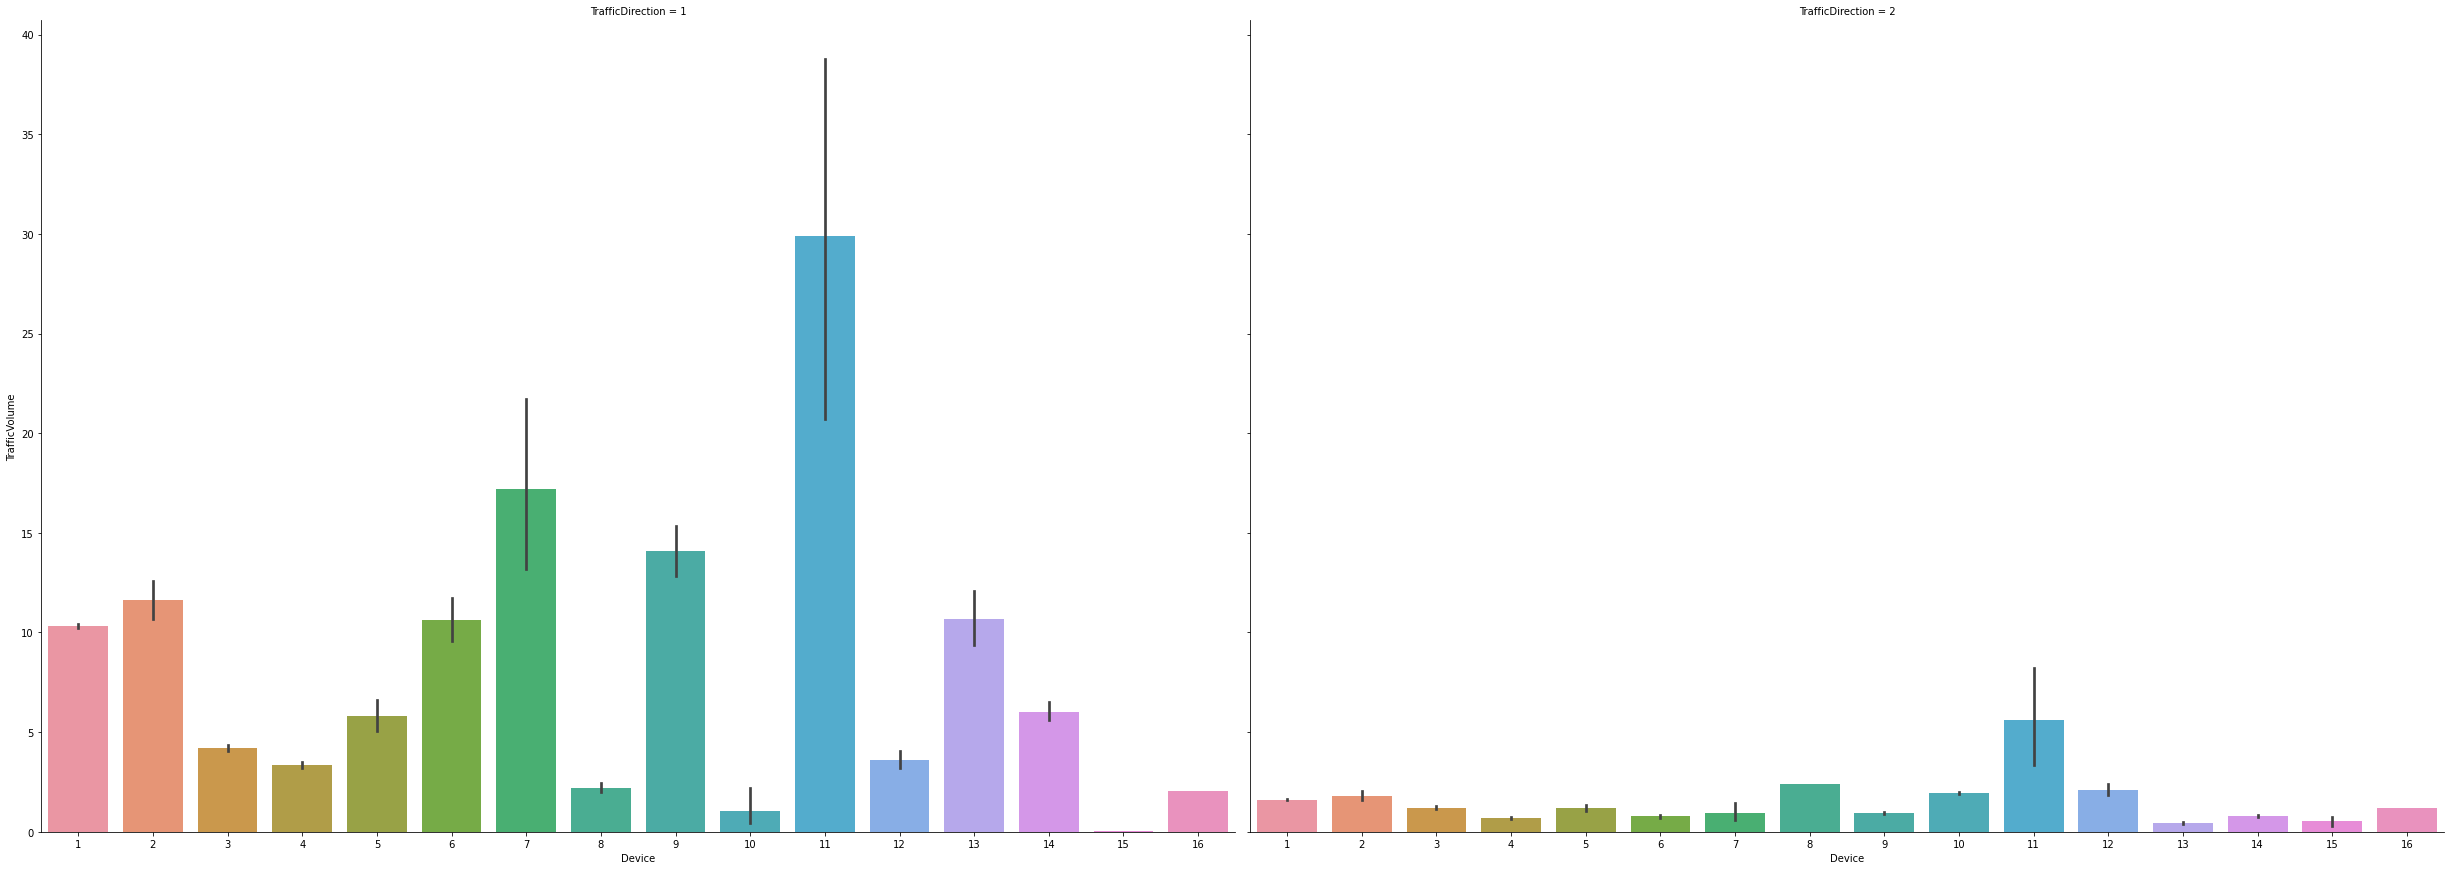

In [154]:
# Our Real Data
g = sns.catplot(x='Device', y='TrafficVolume',
                data=merged, col='TrafficDirection',
                kind="bar",
                height=12, aspect=11.7/8.27);

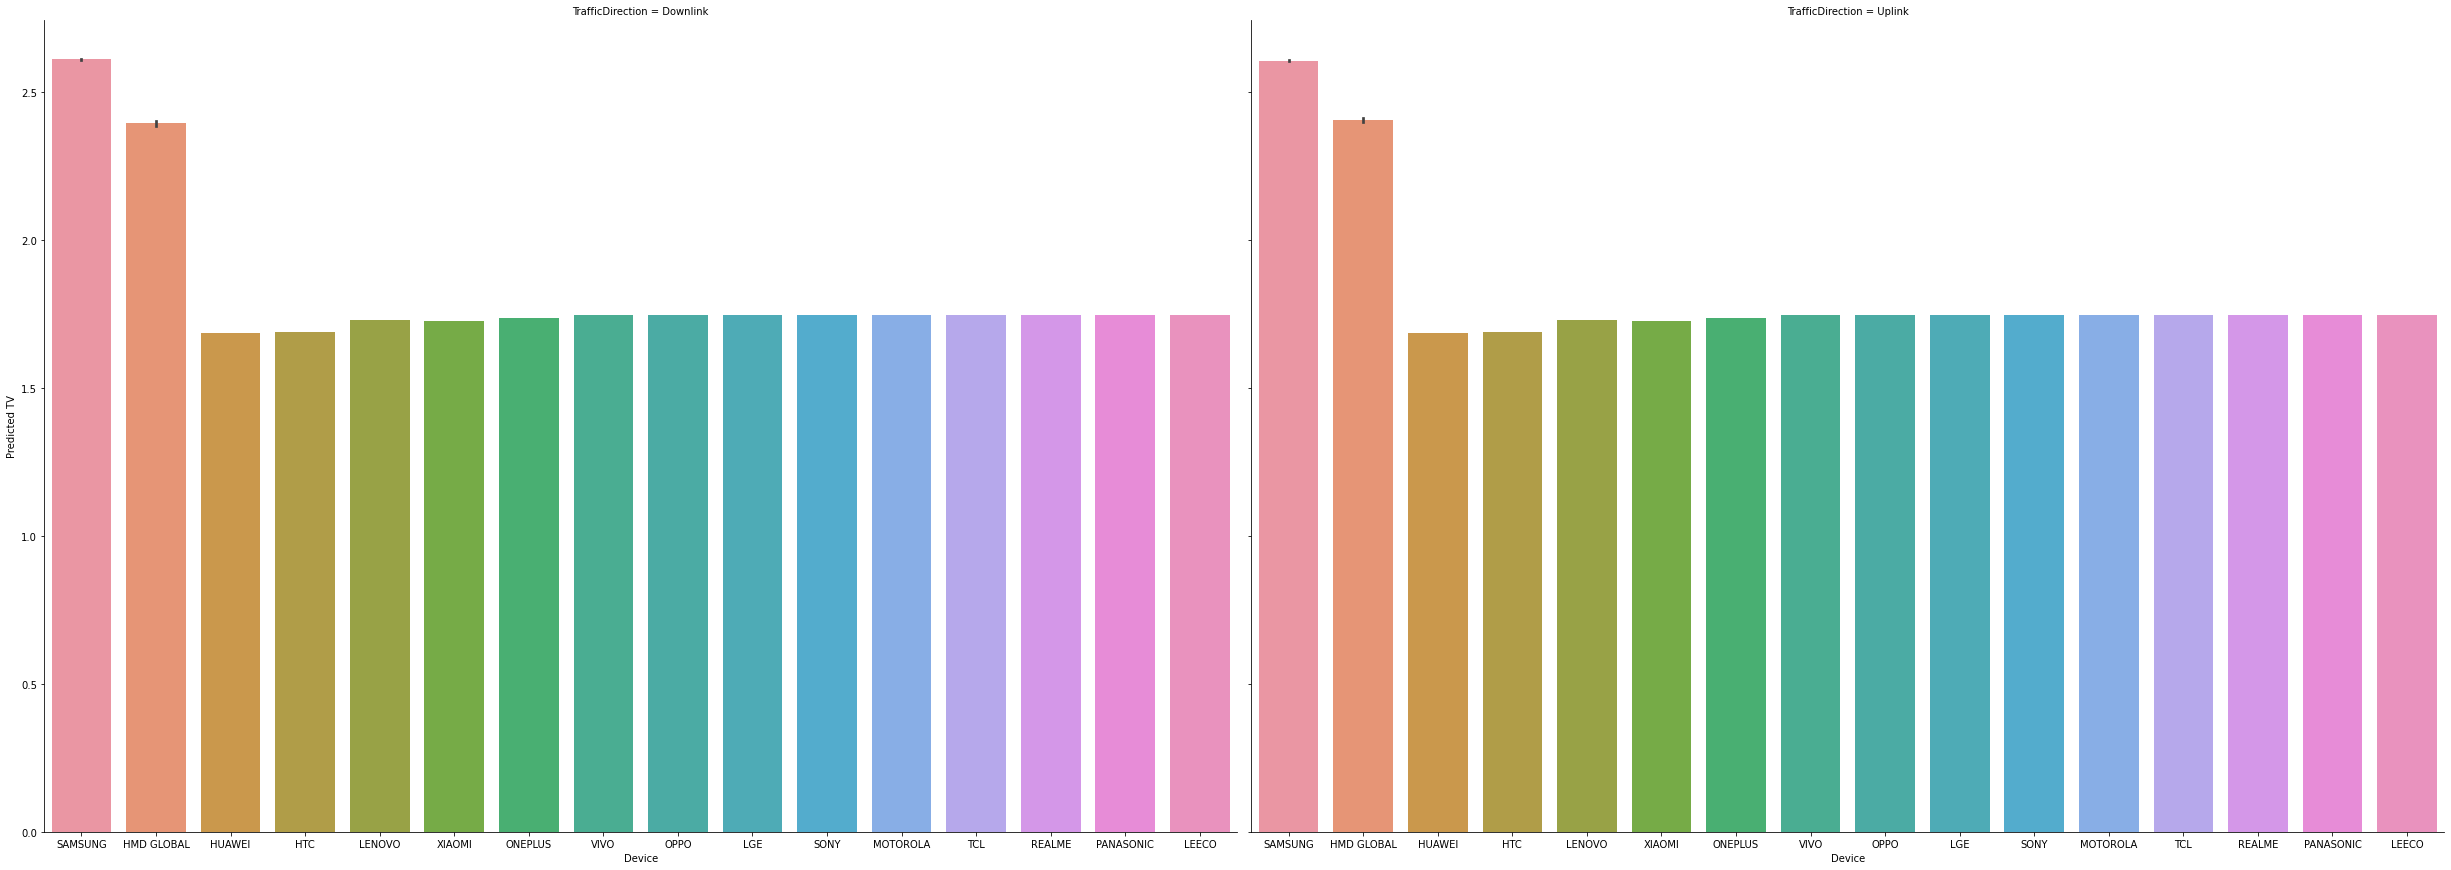

In [140]:
# Data after forecasting
g = sns.catplot(x='Device', y='Predicted TV',
                data=df_test, col='TrafficDirection',
                kind="bar",
                height=12, aspect=11.7/8.27);

**After Comparing both graphes for UpLink and DownLink, initially we can observe that Sony Previously has the most Traffic Volume for both Up&Down Link, yet after enhancing the RSRP and predicting the Traffic Volume accordingly, we find out that the Traffic Volume for almost all the devices increased, yet Samsung showed a segnificant increase in both Up&Down Link Traffic Volume. That shows that the users prefer to use Samsung devices yet if the signal is weak Samsung isn't the best to use instead, Sony is more preferable.**

------------------------------------

# Question 3

**Bonus Question: We have heard about a technology called quantum computing. Reading this paper, can you tell us what could be done better using the same dataset?**